# Image  Classification using Amazon SagemMaker

This notebook is part of my personal development for the project "Image  Classification using Amazon SagemMaker" from which I chose to use RGB images to train a classifier able to idnetify  histologically confirmed skin cancer cases. We'll use SageMaker's Profiler and Debugger (smdebug) to monitor model performance ans system usage and make debugging easier in case of any anomaly.

## Import libraries and set environment

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (679 bytes)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.24.4
    Uninstalling protobuf-4.24.4:
      Successfully uninstalled protobuf-4.24.4


In [1]:
# Import libs
import io
import time
import os

import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import sagemaker
import boto3
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

session = sagemaker.Session()
role = sagemaker.get_execution_role()

bucket = "cancer-classification"
prefix = "data/"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Dataset
The data comes from the Kaggle competition **ISIC 2024 - Skin Cancer Detection with 3D-TBP**.
The original dataset consists of 401,059 images for training and a test set containing only 3 images since the complete testing data is intended to be provided after the competition is finished. However, to avoid large training times and save on SageMaker's runtime we take a sample from the original data: Our complete dataset consists on only 1,000 images stratified by target so the label proportion is kept. For a more thorough description of the data and download visit [here](https://www.kaggle.com/competitions/isic-2024-challenge/overview).

### Download data from Kaggle
(Show dir structure before downloading the data)

In [ ]:
#!kaggle competitions download -c isic-2024-challenge --path ./data/


  0%|          | 0.00/2.00G [00:00<?, ?B/s]
  0%|          | 1.00M/2.00G [00:00<07:37, 4.69MB/s]
  0%|          | 3.00M/2.00G [00:00<04:43, 7.56MB/s]
  0%|          | 4.00M/2.00G [00:00<04:44, 7.54MB/s]
  0%|          | 5.00M/2.00G [00:00<04:45, 7.50MB/s]
  0%|          | 6.00M/2.00G [00:00<04:46, 7.48MB/s]
  0%|          | 7.00M/2.00G [00:01<04:46, 7.47MB/s]
  0%|          | 8.00M/2.00G [00:01<04:47, 7.43MB/s]
  0%|          | 9.00M/2.00G [00:01<04:47, 7.45MB/s]
  0%|          | 10.0M/2.00G [00:01<04:46, 7.46MB/s]
  1%|          | 11.0M/2.00G [00:01<04:48, 7.40MB/s]
  1%|          | 12.0M/2.00G [00:01<04:46, 7.44MB/s]
  1%|          | 13.0M/2.00G [00:01<04:46, 7.45MB/s]
  1%|          | 14.0M/2.00G [00:01<04:47, 7.42MB/s]
  1%|          | 15.0M/2.00G [00:02<04:48, 7.39MB/s]
  1%|          | 16.0M/2.00G [00:02<04:47, 7.42MB/s]
  1%|          | 17.0M/2.00G [00:02<04:47, 7.42MB/s]
  1%|          | 18.0M/2.00G [00:02<04:46, 7.44MB/s]
  1%|          | 19.0M/2.00G [00:02<04:46, 7.44MB/s]
 

In [ ]:
#! cd ./data/ | unzip isic-2024-challenge.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!pwd

'/home/sagemaker-user/cd0385-project-starter/project'

The original data is provided in jpg images but uploading a 1000 images to S3 would require considerable storage so we'll use the HDF5 files and load the images from the byte data contained in these files. Moreover, data processing during training is less memory intensive this way. Labels will be obtained from the metadata which is stored in CSV files. 

In [3]:
# Explore the structure of the hdf5 file
test_img_path = "data/isic-2024-challenge/test-image.hdf5"

with h5py.File(test_img_path, "r") as hdf:
    # Print all groups
    print("Keys: %s" % hdf.keys())
    # Loop over the keys to explore deeper levels
    for key in hdf.keys():
        print(f"\nKey: {key}")
        # Get the object
        obj = hdf[key]
        
        if isinstance(obj, h5py.Group):
            print("Group:")
            for subkey in obj.keys():
                print(f"  {subkey}")
        elif isinstance(obj, h5py.Dataset):
            print("Dataset:")
            print(f"  Shape: {obj.shape}")
            print(f"  Data type: {obj.dtype}")
            # Print the data (optional)
            print(f"  Data: {obj[...]}") 

Keys: <KeysViewHDF5 ['ISIC_0015657', 'ISIC_0015729', 'ISIC_0015740']>

Key: ISIC_0015657
Dataset:
  Shape: ()
  Data type: |S3318
  Data: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x06\x07\x06\x05\x08\x07\x07\x07\t\t\x08\n\x0c\x14\r\x0c\x0b\x0b\x0c\x19\x12\x13\x0f\x14\x1d\x1a\x1f\x1e\x1d\x1a\x1c\x1c $.\' ",#\x1c\x1c(7),01444\x1f\'9=82<.342\xff\xdb\x00C\x01\t\t\t\x0c\x0b\x0c\x18\r\r\x182!\x1c!22222222222222222222222222222222222222222222222222\xff\xc0\x00\x11\x08\x00\x8d\x00\x8d\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x9

### Create training and validation splits from the original dataset

We'll use the meetdata contained in the CSV file to create a data partition containing a given number of images. With this we'll only use a sample or chunk from the original data so the training and HPO jobs do not get to expensive. From this newly created chunk we' ll create 2 hdf5 files, one for each training and validation split. For testing we'll use the originally provided hdf5 file w. 3 images.

Read the CSV file and create splits using that data so we can use IDs to retrieve image data.
Load just the columns of interest to avoid memory usage

In [4]:
full_meta_path = "data/isic-2024-challenge/train-metadata.csv"

cols_of_interest = ["isic_id", "target"]

train_meta_df = pd.read_csv(full_meta_path, usecols=cols_of_interest)

In [5]:
len(train_meta_df)

401059

In [6]:
# Count the number of malignant cases
num_malignant = len(train_meta_df[train_meta_df["target"] == 1])
num_malignant

393

Our original dataset suffers a problem of class imbalance as the number of malignant cases is considerably less than the number of  beningn cases, we'll try to address this to achieve better generalixation from our models. Also, we'll extract a total of 1,000 images for training and validating our models.

In [7]:
malignant_ids = train_meta_df[train_meta_df["target"] == 1]["isic_id"].tolist()
records_ids = []
# To retrieve all the malignant cases
records_ids.extend(malignant_ids)

num_records = 1000

for i in train_meta_df["isic_id"]:
    count = len(records_ids)
    if count >= num_records:
        break
    if i not in records_ids:
        records_ids.append(i)

In [8]:
len(records_ids)

1000

In [9]:
# check that we have uniquevalues
len(set(records_ids))

1000

In [10]:
# Create a df for our partition so we can use 'target' to stratify the splits
partition_df = train_meta_df[train_meta_df["isic_id"].isin(records_ids)]
partition_df.shape

(1000, 2)

In [11]:
X_train, X_val, y_train, y_val = train_test_split(partition_df.isic_id,
                                                  partition_df.target,
                                                  test_size=0.2,
                                                  stratify=partition_df.target)

Save metadata for each split (image_ids and corresponding labels)

In [16]:
train_split_df = pd.DataFrame({'isic_id': X_train, 'target': y_train})
val_split_df = pd.DataFrame({'isic_id': X_val, 'target': y_val})

# Save each split to a CSV file
train_split_df.to_csv("data/isic-2024-challenge/train_split.csv", index=False)
val_split_df.to_csv("data/isic-2024-challenge/val_split.csv", index=False)

### Create HDF5 files for each split

In [17]:
full_img_path = "data/isic-2024-challenge/train-image.hdf5"

In [18]:
def create_hdf5_split(records_array, file_path, target_file):
    '''Function to create a new data partition and store it in a new HDF5 file.
    Params:
        records_array: array-like, array-like object containing the keys to retrieve from the HDF5
        file_path: str, path to the HDF5 file to extract datasets from
        target_file: str, file path name of the new HDF5 file containing the retieved records
    '''
    with h5py.File(file_path, 'r') as file:
        keys_list = list(file.keys())
        records_list = list(records_array)
        with h5py.File(target_file, 'w') as new_file:
            for key in keys_list:
                if key in records_list:
                    data = file[key][()]
                    new_file.create_dataset(key, data=data)
            
            records_written = len(new_file.keys())

    print(f"Succesfully wrote {records_written} records in {target_file}")

In [19]:
val_img_path = "data/isic-2024-challenge/val_split-image.hdf5"

create_hdf5_split(X_val, full_img_path, val_img_path)

Succesfully wrote 200 records in data/isic-2024-challenge/val_split-image.hdf5


In [21]:
%%time
train_img_path = "data/isic-2024-challenge/train_split-image.hdf5"

create_hdf5_split(X_train, full_img_path, train_img_path)

Succesfully wrote 800 records in data/isic-2024-challenge/train_split-image.hdf5
CPU times: total: 7.5 s
Wall time: 16.5 s


### Display a sample image
Let's display an image from the validation dataset to doublecheck that the image data was retrieved succesfylly.

In [2]:
# Define a function to read datasets from a HDF5 file

def read_images(file_path):
    '''Function to read image data from a HDF5 file.
    Params:
        file_path: str, the file path to the HDF5 file.
        
    return: dict, a dictionary in the form of {Image ID: numpy array}"'''
    with h5py.File(file_path, 'r') as file:
        ids_list = list(file.keys())
        images = {}
        for img_id in tqdm(ids_list):
            # Extract the image data
            image_data = file[img_id][()] #retrieve the entire data from each dataset
            image = Image.open(io.BytesIO(image_data))
            images[img_id] = np.array(image)

    return images

100%|██████████| 200/200 [00:01<00:00, 102.55it/s]


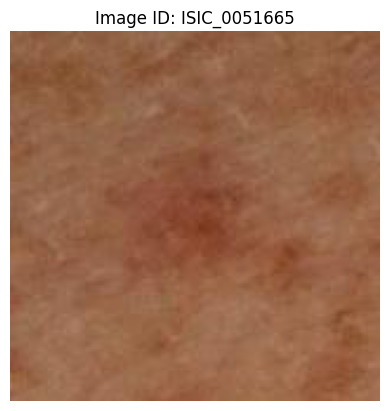

In [23]:
# Read the images from the validation daatset
sample = read_images(val_img_path)

# Access the first image in the dictionary
first_img_id, first_img_array = next(iter(sample.items()))

# Plot the first image
plt.figure()
plt.imshow(first_img_array)
plt.title(f"Image ID: {first_img_id}")
plt.axis('off')
plt.show()

### Upload data to S3
We'll upload images (hdf5) and labels (csv) to the same split directory. Remember that test data has no associated labels.

NOTE: Since we've created separate directories from each split, we'll upload those dirs separately and define the input channels from the obtained S3 URIS.

In [3]:
train_label_path = "data/isic-2024-challenge/train_split.csv"
val_label_path = "data/isic-2024-challenge/val_split.csv"

train_img_path = "data/isic-2024-challenge/train_split-image.hdf5"
val_img_path = "data/isic-2024-challenge/val_split-image.hdf5"
test_img_path = "data/isic-2024-challenge/test-image.hdf5"

In [12]:
# Upload data
training_inputs = session.upload_data(path=train_img_path, bucket=bucket, key_prefix=prefix + "train")
validation_inputs = session.upload_data(path=val_img_path, bucket=bucket, key_prefix=prefix + "validation")
testing_inputs = session.upload_data(path=test_img_path, bucket=bucket, key_prefix=prefix + "test")

In [13]:
session.upload_data(path=train_label_path, bucket=bucket, key_prefix=prefix + "train")
session.upload_data(path=val_label_path, bucket=bucket, key_prefix=prefix + "validation")

's3://cancer-classification/data/validation/val_split.csv'

In [19]:
training_inputs = os.path.dirname(training_inputs)
validation_inputs = os.path.dirname(validation_inputs)
testing_inputs = os.path.dirname(testing_inputs)

Define the inputs to our HPO job.

In [3]:
training_inputs = "s3://cancer-classification/data/train"
validation_inputs = "s3://cancer-classification/data/validation"
testing_inputs = "s3://cancer-classification/data/test"

In [3]:
# Set the input channels usig the URIs from the uplpoad
inputs = {"training": training_inputs,
          "validation": validation_inputs,
          "test": testing_inputs}

In [4]:
inputs

{'training': 's3://cancer-classification/data/train',
 'validation': 's3://cancer-classification/data/validation',
 'test': 's3://cancer-classification/data/test'}

## Hyperparameter Tuning

We use SageMaker's hyperparameter tuner to perform Hyperparameter Optimization and ensure great performance for our trained and later deployed model. The hyperparemters to tune are:

- Batch size: this parameter can improve in training time and resource utilization such as efficient GPU utilization during training, validation and even testing.
- Epochs: we won't try a large range of epochs since we are finetuning a pretrained model. Additionally we save on runtime usage.
- Learning rate: probably one of the most unpredictable hyperparameters, but a good value to start is around 1e-2.

### Instance the Estimator


In [12]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "scripts/hpo.py",
    role = role,
    py_version = "py38",
    framework_version = "1.9",
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge"
)

### Configure hyperparameter tuner

The metric_definitions parameter is crucial when using SageMaker’s Hyperparameter Tuner, as it tells the tuner how to interpret and extract metrics from the training output logs. The regular expression is used to search the output logs for the metric.

In [13]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "epochs": IntegerParameter(5, 10)
}

objective_metric_name = "Average validation loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average validation loss",
                       "Regex": "Validation Loss: ([+-]?[0-9\\.]+)"}]

# Instance the hyperparameter tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name="hpo-resnet50-01"
)

In [14]:
%%time
tuner.fit(inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.................................................................................................................................................................................................................!
CPU times: user 1.13 s, sys: 70.8 ms, total: 1.2 s
Wall time: 17min 55s


In [15]:
# Get the best estimators and the best hyperparameters

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-08-28 00:17:58 Starting - Found matching resource for reuse
2024-08-28 00:17:58 Downloading - Downloading the training image
2024-08-28 00:17:58 Training - Training image download completed. Training in progress.
2024-08-28 00:17:58 Uploading - Uploading generated training model
2024-08-28 00:17:58 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"Average validation loss"',
 'epochs': '10',
 'learning_rate': '0.0032272529904668217',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-08-28-00-00-48-820"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-533701990481/pytorch-training-2024-08-28-00-00-48-820/source/sourcedir.tar.gz"'}

In [16]:
best_hyperparameters = best_estimator.hyperparameters()
# Extract each hyperparameter as a string
batch_size = str(best_hyperparameters.get("batch_size", ""))
epochs = str(best_hyperparameters.get("epochs", ""))
learning_rate = str(best_hyperparameters.get("learning_rate", ""))

best_params_str = f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}"
print(best_params_str)

Batch Size: , Epochs: 10, Learning Rate: 0.0032272529904668217


Before training our model to deploy, let's try with a higher batch number...

In [17]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([64, 128]),
    "epochs": IntegerParameter(5, 10)
}

objective_metric_name = "Average validation loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Average validation loss",
                       "Regex": "Validation Loss: ([+-]?[0-9\\.]+)"}]

# Instance the hyperparameter tuner
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type,
    base_tuning_job_name="hpo-resnet50-01"
)

In [18]:
%%time
tuner.fit(inputs, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................!
CPU times: user 939 ms, sys: 118 ms, total: 1.06 s
Wall time: 16min 57s


In [19]:
# Get the best estimators and the best hyperparameters

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-08-28 00:52:40 Starting - Found matching resource for reuse
2024-08-28 00:52:40 Downloading - Downloading the training image
2024-08-28 00:52:40 Training - Training image download completed. Training in progress.
2024-08-28 00:52:40 Uploading - Uploading generated training model
2024-08-28 00:52:40 Completed - Resource released due to keep alive period expiry


{'_tuning_objective_metric': '"Average validation loss"',
 'batch_size': '"128"',
 'epochs': '7',
 'learning_rate': '0.010719896532937515',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-08-28-00-36-23-714"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-533701990481/pytorch-training-2024-08-28-00-36-23-714/source/sourcedir.tar.gz"'}

In [20]:
best_hyperparameters = best_estimator.hyperparameters()
# Extract each hyperparameter as a string
batch_size = str(best_hyperparameters.get("batch_size", ""))
epochs = str(best_hyperparameters.get("epochs", ""))
learning_rate = str(best_hyperparameters.get("learning_rate", ""))

best_params_str = f"Batch Size: {batch_size}, Epochs: {epochs}, Learning Rate: {learning_rate}"
print(best_params_str)

Batch Size: "128", Epochs: 7, Learning Rate: 0.010719896532937515


## Model Profiling and Debugging

### Set hyperparmeters for our training job
We'll train our model with the best hyperparameters from the last HPO training jobs.

In [3]:
# Set the parameters for the submitting script
# (we're working on a notebook to make it easier but it can also be done in a script)

hyperparameters = {
    "batch_size": 128,
    "epochs": 7,
    "learning_rate": 0.01
}

#### Key concepts of Amazon SageMaker Debugger

Amazon SageMaker Debugger lets you go beyond just looking at scalars like losses and accuracies during training and gives you full visibility into all tensors 'flowing through the graph' during training. Furthermore, it helps you monitor your training in near real time using rules and provides you alerts, once it has detected inconsistency in training flow.

Concepts
- Tensors: These represent the state of the training network at intermediate points during its execution
- Debug Hook: Hook is the construct with which Amazon SageMaker Debugger looks into the training process and captures the tensors requested at the desired step intervals
- Rule: A logical construct, implemented as Python code, which helps analyze the tensors captured by the hook and report anomalies, if at all


### Create rules and hooks

In [4]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

# Create debugging and profiling rules
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()), 
]

In [5]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

# Instance profiler and debugger configs
debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"})

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(num_steps=10))

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


### Create the PT estimator

In [7]:
from sagemaker.pytorch import PyTorch
#role = sagemaker.get_execution_role()

estimator = PyTorch(
    role=role,
    base_job_name="smdebugger-resnet50-cancerClassification", #Change for every training job
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="scripts/train_model.py",
    framework_version="1.9",
    py_version="py38",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

### Train the estimator 
This time our model will not perform validation as we already performed HPO, so we'll use a bigger dataset to test the model

In [4]:
inputs = {"training": training_inputs,
          "test": validation_inputs}

In [11]:
%%time
# Train our model
estimator.fit(inputs, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722


2024-08-28 23:12:58 Starting - Starting the training job...
2024-08-28 23:13:26 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-08-28 23:13:52 Downloading - Downloading the training image..............................
2024-08-28 23:18:51 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-28 23:19:02,316 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-28 23:19:02,350 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-28 23:19:02,354 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-08-28 23:19:02,665 sagemaker-training-toolkit INFO     Invoking user script
T

Prepare for debugging and profiling analysis

In [15]:
#import boto3

boto_session = boto3.session.Session()
region = boto_session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722
Region: us-east-1


In [16]:
# Show training job description
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=training_job_name)
description

{'TrainingJobName': 'smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:533701990481:training-job/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch_size': '128',
  'epochs': '7',
  'learning_rate': '0.01',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-

### Checking Training Performance

A Trial is an object used to interact with and analyze the debugging artifacts generated during a training job. SageMaker Debugger collects data such as tensors, metrics, and other relevant information at different points during the training process. These artifacts are stored in a specific path (e.g., in S3), and the Trial object allows you to access, query, and visualize this data.

In [17]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

# Instance the trial object
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2024-08-28 23:26:13.273 default:259 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2024-08-28 23:26:13.293 default:259 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/debug-output


#### Print the names of tracked tensors for both train and evaluation, and the number of datapoints for each tensors

In [18]:
print(f"Tensor names: \n {trial.tensor_names()}")

[2024-08-28 23:26:22.254 default:259 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-28 23:26:23.272 default:259 INFO trial.py:210] Loaded all steps
Tensor names: 
 ['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight']


In [19]:
print(f'Datapoints in the training tensor: {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))}\n')
print(f'Datapoints in the evaluation tensor: {len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))}')

Datapoints in the training tensor: 1

Datapoints in the evaluation tensor: 0


### Check system usage

The TrainingJob object tj encapsulates all the information and utilities required to interact with the profiling data collected during the specified training job.

In [5]:
!pip show smdebug

Name: smdebug
Version: 1.0.34
Summary: Amazon SageMaker Debugger is an offering from AWS which helps you automate the debugging of machine learning training jobs.
Home-page: https://github.com/awslabs/sagemaker-debugger
Author: AWS DeepLearning Team
Author-email: 
License: Apache License Version 2.0
Location: /opt/conda/lib/python3.10/site-packages
Requires: boto3, numpy, packaging, protobuf, pyinstrument
Required-by: 


The compatible version of Bokeh for use with smdebug-1.0.34 is Bokeh 2.4.3. There have been issues reported with Bokeh 3.0 where certain functionalities, like plotting, may not work as expected.

In [6]:
try:
    import bokeh
    if bokeh.__version__ != "2.4.3":
        !pip uninstall -y bokeh
        !pip install bokeh==2.4.3
except ImportError:
    !pip install bokeh==2.4.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 64.0 MB/s eta 0:00:00:00:0100:01


In [8]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-533701990481/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/profiler-output


Profiler data from system is available


In [9]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts 

# Display system metrics
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"]
)

[2024-08-30 00:36:10.821 default:115 INFO metrics_reader_base.py:134] Getting 10 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'GPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'CPUUtilization-nodeid:algo-1'}


## Display the Profiler Report
We will fetch the profiler report from the S3 bucket where it was stored and display it.

In [26]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report at {rule_output_path}")

You will find the profiler report at s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output


In [27]:
! aws s3 ls {rule_output_path} --recursive

2024-08-28 23:22:26     372312 smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-08-28 23:22:26     220765 smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-08-28 23:22:21        192 smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-08-28 23:22:21      11289 smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-08-28 23:22:21       2048 smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-08-28 23:22:21        130 smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIn

In [28]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to Profi

In [29]:
#import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [30]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## Model Deploying

We can directly deploy the model from the estimator, but if we want to make further development without mantaining an active endpoint (and generate costs) we can create a Model object from the model artifact.

In [32]:
#predictor = estimator.deploy(instance_type = "ml.c5.large", initial_instance_count=1)

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-35-47-397/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: smdebugger-resnet50-cancerClassificatio-2024-08-28-23-35-47-397
INFO:sagemaker:Creating endpoint-config with name smdebugger-resnet50-cancerClassificatio-2024-08-28-23-35-47-397
INFO:sagemaker:Creating endpoint with name smdebugger-resnet50-cancerClassificatio-2024-08-28-23-35-47-397


-------!

Create a PT model using the model artifact obtained from the training job.
NOTE: for this we need an inference script to use as entry point, ours is located at 'scripts/inference.py'

In [4]:
from sagemaker.pytorch import PyTorchModel

model_data = "s3://sagemaker-us-east-1-533701990481/smdebugger-resnet50-cancerClassificatio-2024-08-28-23-12-57-722/output/model.tar.gz"

model = PyTorchModel(
    role=role,
    entry_point="scripts/inference.py",
    model_data=model_data,
    py_version="py38",
    framework_version="1.9"
)

The instance type is very important when training large models because they need enough computation resources, not only to process along layers but to load complex data.
Our inference script 'inference.py' donwnloads a pretrained ResNet50 model so inference and model loading make take a while (~10 mins) so we need to add special parameters when deploying our model to avoid runtime issues.

In [6]:
predictor = model.deploy(instance_type="ml.c5.xlarge",
                        initial_instance_count=1,
                         ModelDataDownloadTimeoutInSeconds = 1200,
                        ContainerStartupHealthCheckTimeoutInSeconds = 1200)

-------!

### Make predictions on out testing data
Well use the original test set which contains only 3 images so we can load data fast. 

In [7]:
predictor.endpoint_name

'pytorch-inference-2024-08-29-20-32-03-768'

In [8]:
test_file = "data/isic-2024-challenge/test-image.hdf5"

test_images = read_images(test_file)

test_img_id, test_img_array = next(iter(test_images.items()))

100%|██████████| 3/3 [00:00<00:00, 149.76it/s]


In [9]:
from torchvision import transforms

# Convert np array to image
image = Image.fromarray(test_img_array)

#Create needed data transformations
# Pretrained params used for efficientNet_b4 during pretraining
pretrained_size = 380
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transformation = transforms.Compose([
    transforms.Resize(pretrained_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

tensor_image = transformation(image)

In [19]:
tensor_image.shape

torch.Size([3, 380, 380])

Prepare image for prediction

*WE HAVE 2 INPUT OPTIONS DEPENDING ON HOW WE PERFORM INFERENCE, WITH THE INFERENCE METHOD OR FROM INVOKING AN ENDPOINT: AN UNSQUEEZED TENSOR OR A JSON PAYLOAD*

DE HECHO TENEMOS 3 OPCIONES CONTANDO EL MODO DE CAMBIAR EL CONTENT_TYPE CON EL ARGUMENTO, BUSCAR EL CODIGO PARA LOS OTROS 2 METODOS Y AGREGARLO COMO MD

In [11]:
import torch
import json

tensor_image_large = tensor_image.unsqueeze(0) #shape must now be (1, 3 , 380, 380)
payload = tensor_image_large.numpy().tobytes()

# or if needs to be an array
#payload = json.dumps(tensor_image.tolist())

In [18]:
response = predictor.predict(data=tensor_image_large)
predicted_label = np.argmax(response, 1)[0]

print(f"Predicted label for our test image: {predicted_label}")

Predicted label for our test image: 1


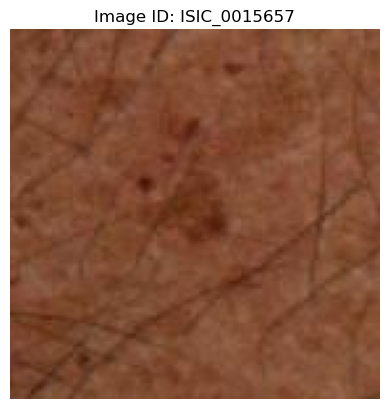

In [20]:
# Plot the first image
plt.figure()
plt.imshow(test_img_array)
plt.title(f"Image ID: {test_img_id}")
plt.axis('off')
plt.show()

In [ ]:
runtime = boto3.client('runtime.sagemaker')
response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType='application/json', Body=image)

In [26]:
#preprocessed = tensor_image_large.to("cpu")
response = predictor.predict(data=payload, accept="application/json")

TypeError: Predictor.predict() got an unexpected keyword argument 'accept'

In [ ]:
predicted_class = torch.tensor(json.loads(response))
predicted_class

In [63]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: smdebugger-resnet50-cancerClassificatio-2024-08-28-23-35-47-397
INFO:sagemaker:Deleting endpoint with name: smdebugger-resnet50-cancerClassificatio-2024-08-28-23-35-47-397


#### References

*International Skin Imaging Collaboration. SLICE-3D 2024 Challenge Dataset. International Skin Imaging Collaboration https://doi.org/10.34970/2024-slice-3d (2024).*
*Creative Commons Attribution-Non Commercial 4.0 International License.*
*The dataset was generated by the International Skin Imaging Collaboration (ISIC) and images are from the following sources: Hospital Clínic de Barcelona, Memorial Sloan Kettering Cancer Center, Hospital of Basel, FNQH Cairns, The University of Queensland, Melanoma Institute Australia, Monash University and Alfred Health, University of Athens Medical School, and Medical University of Vienna.*